Training runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
Testing runs: ['TS_5_4', 'TS_69_2', 'TS_6_4']
Extra training runs not in testing: ['TS_99_9', 'TS_73_6', 'TS_86_3', 'TS_6_6']
Number of train tomograms: 1
Number of test tomograms: 3
Type: <class 'numpy.ndarray'>
Element Type: <class 'numpy.ndarray'>
Shape: (184, 630, 630)


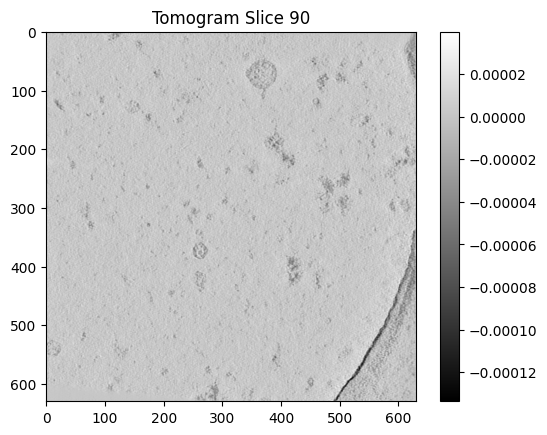

Total labeled particles in TS_5_4: 140
Sample particle locations:
               particle         x         y        z  radius
114       thyroglobulin  433.8644  182.2464  45.5595    13.0
42   beta-galactosidase  195.9181   70.1502  37.1229     9.0
20             ribosome  462.0799  280.2160  51.3430    15.0
117       thyroglobulin  229.3097  186.9880  55.5296    13.0
120       thyroglobulin  308.8296  234.9548  83.9110    13.0
Unique Particle Types and Their Radii:
              particle  radius
0             ribosome    15.0
1  virus-like-particle    13.5
2        thyroglobulin    13.0
3   beta-galactosidase     9.0
4         beta-amylase     6.5
5         apo-ferritin     6.0


In [1]:
#!/usr/bin/env python
# coding: utf-8

# ============================
# Imports
# ============================
import os
import json
import random
import itertools
import gc
from collections import defaultdict, deque

import numpy as np
import pandas as pd
import zarr
from matplotlib import pyplot as plt
from matplotlib import patches
from tqdm import tqdm

from numba import njit, prange

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

import copick  # Assumes copick is available in your PYTHONPATH

# ============================
# Data Loading and Preprocessing
# ============================
def get_copick_root(split):
    config_path = '../../../copick_config.json' if split == 'train' else '../../../copick_config_test.json'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")
    return copick.from_file(config_path)

def get_static_tomogram(run_name, split='train', tomo_type='denoised', zarr_group_idx=0):
    copick_root = get_copick_root(split)
    run = copick_root.get_run(run_name)
    voxel_spacing = run.get_voxel_spacing(10.000)
    tomogram = voxel_spacing.get_tomogram(tomo_type)
    zarr_store = tomogram.zarr()
    zarr_group = zarr.open(zarr_store, mode='r')
    try:
        tomo_vals = zarr_group[str(zarr_group_idx)][:]
    except KeyError:
        raise KeyError(f"Zarr group index {zarr_group_idx} not found in the store.")
    return tomo_vals

# Load configurations and run names
copick_root_train = get_copick_root('train')
copick_root_test  = get_copick_root('test')

training_runs = copick_root_train.runs
testing_runs  = copick_root_test.runs

training_run_names = [run.name for run in training_runs]
testing_run_names  = [run.name for run in testing_runs]
extra_training_run_names = list(set(training_run_names) - set(testing_run_names))

print(f'Training runs: {training_run_names}')
print(f'Testing runs: {testing_run_names}')
print(f'Extra training runs not in testing: {extra_training_run_names}')

# Load tomograms
tomograms_train = []
tomograms_test  = []

for training_run_name in training_run_names[:1]:
    try:
        tomo = get_static_tomogram(run_name=training_run_name, split='train')
        tomograms_train.append({'run': training_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {training_run_name}: {e}")

for testing_run_name in testing_run_names:
    try:
        tomo = get_static_tomogram(run_name=testing_run_name, split='test')
        tomograms_test.append({'run': testing_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {testing_run_name}: {e}")

print(f'Number of train tomograms: {len(tomograms_train)}')
print(f'Number of test tomograms: {len(tomograms_test)}')

if tomograms_train:
    sample_tomo = tomograms_train[0]['tomogram']
    print(f"Type: {type(sample_tomo)}")
    print(f"Element Type: {type(sample_tomo[0])}")
    print(f"Shape: {sample_tomo.shape}")
else:
    print("No training tomograms loaded.")

# Visualize a sample slice
if tomograms_train:
    slice_index = 90
    if slice_index < tomograms_train[0]['tomogram'].shape[0]:
        plt.imshow(tomograms_train[0]['tomogram'][slice_index], cmap='gray')
        plt.title(f"Tomogram Slice {slice_index}")
        plt.colorbar()
        plt.show()
    else:
        print(f"Slice index {slice_index} out of range.")
else:
    print("No training tomograms to visualize.")

# ============================
# Label Extraction and Ground Truth
# ============================
def get_label_locations(run_name, copick_root, voxel_spacing=10):
    picks_folder = os.path.join(copick_root.config.overlay_root, 'ExperimentRuns', run_name, 'Picks')
    if not os.path.exists(picks_folder):
        raise FileNotFoundError(f"Picks folder not found: {picks_folder}")
    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            particle_name = json_file[:-5]
            picks[particle_name] = np.array([
                [point['location']['x'] / voxel_spacing,
                 point['location']['y'] / voxel_spacing,
                 point['location']['z'] / voxel_spacing]
                for point in pick_data.get('points', [])
            ])
    return picks

def get_particle_locations(run_name):
    rows = []
    label_data = get_label_locations(run_name, copick_root_train)
    for particle, locations in label_data.items():
        matching_particles = [obj.radius for obj in copick_root_train.config.pickable_objects if obj.name == particle]
        if not matching_particles:
            print(f"No matching particle found for {particle} in run {run_name}")
            continue
        radius = matching_particles[0] / 10
        for loc in locations:
            rows.append({'particle': particle, 'x': loc[0], 'y': loc[1], 'z': loc[2], 'radius': radius})
    return pd.DataFrame(rows)

# Attach particle locations to tomograms
for run in training_run_names:
    particle_locations = get_particle_locations(run)
    for tomo in tomograms_train:
        if tomo['run'] == run:
            tomo['particle_locations'] = particle_locations

if tomograms_train:
    print(f"Total labeled particles in {tomograms_train[0]['run']}: {len(tomograms_train[0]['particle_locations'])}")
    print("Sample particle locations:")
    print(tomograms_train[0]['particle_locations'].sample(5))

# Compute ground truth bounding boxes
unique_particles = pd.concat(
    [tomo['particle_locations'][['particle','radius']].drop_duplicates() for tomo in tomograms_train],
    axis=0
).drop_duplicates()
particle_types = sorted(unique_particles['particle'].unique())
particle_sizes = {row['particle']: row['radius'] for row in unique_particles.to_dict(orient='records')}
print("Unique Particle Types and Their Radii:")
print(unique_particles.sort_values(by='radius', ascending=False).reset_index(drop=True))

In [2]:

def compute_ground_truth_boxes(df, label_to_id):
    x_min = df['x'] - df['radius']
    x_max = df['x'] + df['radius']
    y_min = df['y'] - df['radius']
    y_max = df['y'] + df['radius']
    z_min = df['z'] - df['radius']
    z_max = df['z'] + df['radius']
    boxes = np.stack([x_min, y_min, z_min, x_max, y_max, z_max], axis=1)
    for label in df['particle'].unique():
        if label not in label_to_id:
            label_to_id[label] = max(label_to_id.values()) + 1 if label_to_id else 0
    encoded_labels = df['particle'].map(label_to_id).values
    return boxes, encoded_labels

label_to_id = {}
for tomo in tomograms_train:
    boxes, encoded_labels = compute_ground_truth_boxes(tomo['particle_locations'], label_to_id)
    tomo['ground_truth_boxes'] = boxes
    tomo['ground_truth_labels'] = encoded_labels
    print(f'Run {tomo["run"]}: {len(boxes)} ground truth boxes')

id_to_label = {idx: label for label, idx in label_to_id.items()}

# For network input, add a channel dimension
for tomo in tomograms_train:
    tomo['tomogram_with_channel'] = np.expand_dims(tomo['tomogram'], axis=-1)
print(f"Tomogram shape: {tomograms_train[0]['tomogram'].shape}")
print(f"With channel shape: {tomograms_train[0]['tomogram_with_channel'].shape}")

Run TS_5_4: 140 ground truth boxes
Tomogram shape: (184, 630, 630)
With channel shape: (184, 630, 630, 1)


In [3]:

# ============================
# Backbone and Anchor Generation
# ============================
def build_backbone(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    return keras.Model(inputs=inputs, outputs=x, name='backbone')

def calculate_cumulative_stride(backbone_model):
    stride_z = stride_y = stride_x = 1
    for layer in backbone_model.layers:
        if isinstance(layer, layers.MaxPooling3D):
            s = layer.strides
            stride_z *= s[0]
            stride_y *= s[1]
            stride_x *= s[2]
    return stride_z, stride_y, stride_x

backbone = build_backbone(tomograms_train[0]['tomogram_with_channel'].shape)
feature_map = backbone.output
print(f'Input shape: {tomograms_train[0]["tomogram_with_channel"].shape}')
print(f'Feature map shape: {feature_map.shape}')
stride_z, stride_y, stride_x = calculate_cumulative_stride(backbone)
print(f"Cumulative strides - Z: {stride_z}, Y: {stride_y}, X: {stride_x}")

Input shape: (184, 630, 630, 1)
Feature map shape: (None, 46, 158, 158, 64)
Cumulative strides - Z: 4, Y: 4, X: 4


In [4]:

# Define anchor generation parameters
scales = sorted(np.array(list(particle_sizes.values())) / stride_z * 2)
print(f"Anchor scales: {scales}")
aspect_ratios = [(1, 1, 1)]
boxes_per_anchors = len(scales) * len(aspect_ratios)

@njit
def floor_div(a, b):
    return np.floor(a / b).astype(np.int32)

def get_grid_indices(boxes, grid_min, grid_cell_size, grid_size):
    min_indices = floor_div(boxes[:, :3] - grid_min, np.array(grid_cell_size))
    max_indices = floor_div(boxes[:, 3:6] - grid_min, np.array(grid_cell_size))
    min_indices = np.maximum(min_indices, 0)
    max_indices = np.minimum(max_indices, np.array(grid_size) - 1)
    return min_indices, max_indices

def assign_gt_to_grid(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size):
    M = ground_truth_boxes_fm.shape[0]
    gt_min_idx, gt_max_idx = get_grid_indices(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size)
    grid_dict = defaultdict(list)
    for gt_idx in range(M):
        x_min, y_min, z_min = gt_min_idx[gt_idx]
        x_max, y_max, z_max = gt_max_idx[gt_idx]
        for x in range(x_min, x_max + 1):
            for y in range(y_min, y_max + 1):
                for z in range(z_min, z_max + 1):
                    grid_id = x * grid_size[1] * grid_size[2] + y * grid_size[2] + z
                    grid_dict[grid_id].append(gt_idx)
    return grid_dict

def generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios):
    scales = np.array(scales)
    aspect_ratios = np.array(aspect_ratios)
    num_scales = scales.shape[0]
    num_ratios = aspect_ratios.shape[0]
    scales_repeated = np.repeat(scales, num_ratios)
    aspect_ratios_tiled = np.tile(aspect_ratios, (num_scales, 1))
    sizes = scales_repeated[:, np.newaxis] * aspect_ratios_tiled
    zz, yy, xx = np.meshgrid(centers_z, centers_y, centers_x, indexing='ij')
    centers = np.stack([xx, yy, zz], axis=-1).reshape(-1, 3)
    N = centers.shape[0]
    M = sizes.shape[0]
    centers_expanded = centers[:, np.newaxis, :]
    sizes_expanded = sizes[np.newaxis, :, :]
    mins = centers_expanded - sizes_expanded / 2.0
    maxs = centers_expanded + sizes_expanded / 2.0
    anchor_boxes = np.concatenate([mins, maxs], axis=-1).reshape(-1, 6)
    anchor_centres = np.repeat(centers, M, axis=0)
    return anchor_boxes, anchor_centres

def clip_boxes(anchor_boxes, input_shape):
    D_max, H_max, W_max = input_shape[1], input_shape[2], input_shape[3]
    anchor_boxes[:, 0] = np.clip(anchor_boxes[:, 0], 0, W_max - 1)
    anchor_boxes[:, 1] = np.clip(anchor_boxes[:, 1], 0, H_max - 1)
    anchor_boxes[:, 2] = np.clip(anchor_boxes[:, 2], 0, D_max - 1)
    anchor_boxes[:, 3] = np.clip(anchor_boxes[:, 3], 0, W_max - 1)
    anchor_boxes[:, 4] = np.clip(anchor_boxes[:, 4], 0, H_max - 1)
    anchor_boxes[:, 5] = np.clip(anchor_boxes[:, 5], 0, D_max - 1)
    return anchor_boxes

def create_anchors(feature_map_shape, scales, aspect_ratios):
    D, H, W = feature_map_shape[1:4]
    centers_z = np.arange(D)
    centers_y = np.arange(H)
    centers_x = np.arange(W)
    anchor_boxes, anchor_centres = generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios)
    anchor_boxes = clip_boxes(anchor_boxes, feature_map_shape)
    return anchor_boxes, anchor_centres

print("Generating anchors for each tomogram...")
for tomo in tqdm(tomograms_train):
    tomo['anchor_boxes'], tomo['anchor_centres'] = create_anchors(feature_map.shape, scales, aspect_ratios)

print(f"Generated {tomograms_train[-1]['anchor_boxes'].shape[0]} anchor boxes.")
print("Sample anchor box diameters (feature map space):")
print(np.unique(tomograms_train[-1]['anchor_boxes'][:, 4] - tomograms_train[-1]['anchor_boxes'][:, 1]))
print("Anchor boxes shape:", tomograms_train[-1]['anchor_boxes'].shape)
print("Anchor centres shape:", tomograms_train[-1]['anchor_centres'].shape)

Anchor scales: [np.float64(3.0), np.float64(3.25), np.float64(4.5), np.float64(6.5), np.float64(6.75), np.float64(7.5)]
Generating anchors for each tomogram...


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

Generated 6890064 anchor boxes.
Sample anchor box diameters (feature map space):
[1.5   1.625 2.25  2.5   2.625 3.    3.25  3.375 3.75  4.25  4.375 4.5
 4.75  5.25  5.375 5.75  6.25  6.375 6.5   6.75  7.5  ]
Anchor boxes shape: (6890064, 6)
Anchor centres shape: (6890064, 3)


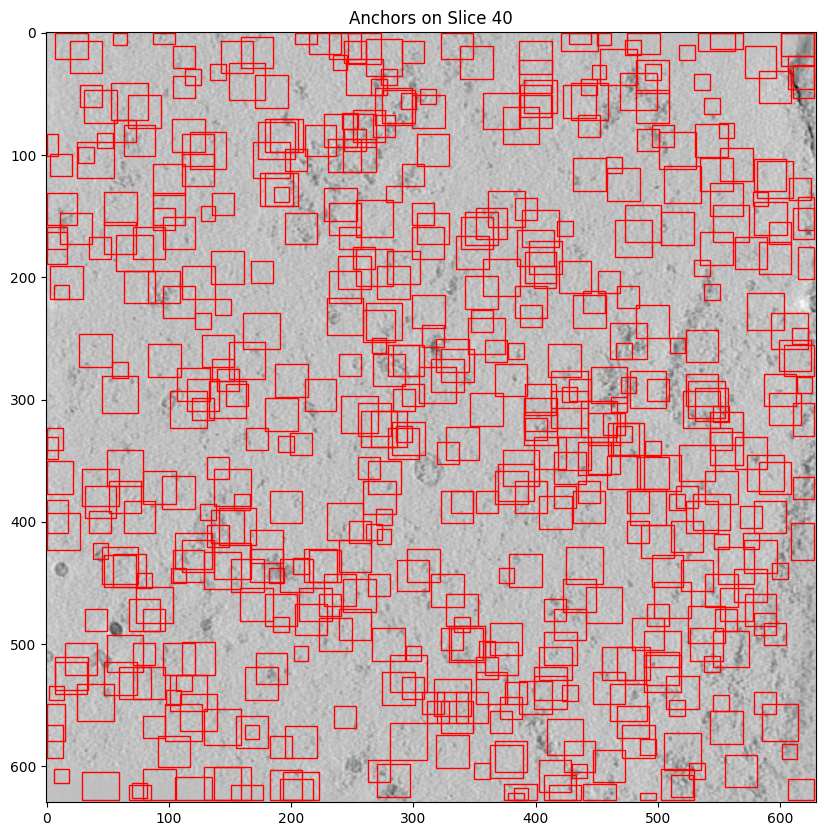

In [5]:

def visualize_anchors(tomogram, anchor_boxes, slice_index, strides, max_anchors=100):
    plt.figure(figsize=(10, 10))
    plt.imshow(tomogram[slice_index], cmap='gray')
    ax = plt.gca()
    indices = np.random.choice(anchor_boxes.shape[0], size=max_anchors, replace=False)
    for anchor in anchor_boxes[indices]:
        x_min = anchor[0] * strides[0]
        y_min = anchor[1] * strides[1]
        x_max = anchor[3] * strides[0]
        y_max = anchor[4] * strides[1]
        if anchor[2] <= slice_index < anchor[5]:
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.title(f"Anchors on Slice {slice_index}")
    plt.show()

slice_index = 40
strides = (stride_z, stride_y, stride_x)
visualize_anchors(tomograms_train[0]['tomogram'], tomograms_train[0]['anchor_boxes'], slice_index, strides, max_anchors=5000)

In [ ]:
# ============================
# Anchor Matching Functions
# ============================
@njit(parallel=True)
def compute_iou_deltas_numba(anchor_boxes, gt_boxes, stride_array, deltas):
    K = anchor_boxes.shape[0]
    for i in prange(K):
        x_min_a = anchor_boxes[i, 0] * stride_array[0]
        y_min_a = anchor_boxes[i, 1] * stride_array[1]
        z_min_a = anchor_boxes[i, 2] * stride_array[2]
        x_max_a = anchor_boxes[i, 3] * stride_array[3]
        y_max_a = anchor_boxes[i, 4] * stride_array[4]
        z_max_a = anchor_boxes[i, 5] * stride_array[5]
        x_a = (x_min_a + x_max_a) / 2.0
        y_a = (y_min_a + y_max_a) / 2.0
        z_a = (z_min_a + z_max_a) / 2.0
        w_a = x_max_a - x_min_a
        h_a = y_max_a - y_min_a
        d_a = z_max_a - z_min_a
        x_min_g = gt_boxes[i, 0] * stride_array[0]
        y_min_g = gt_boxes[i, 1] * stride_array[1]
        z_min_g = gt_boxes[i, 2] * stride_array[2]
        x_max_g = gt_boxes[i, 3] * stride_array[3]
        y_max_g = gt_boxes[i, 4] * stride_array[4]
        z_max_g = gt_boxes[i, 5] * stride_array[5]
        x_g = (x_min_g + x_max_g) / 2.0
        y_g = (y_min_g + y_max_g) / 2.0
        z_g = (z_min_g + z_max_g) / 2.0
        w_g = x_max_g - x_min_g
        h_g = y_max_g - y_min_g
        d_g = z_max_g - z_min_g
        dx = (x_g - x_a) / w_a
        dy = (y_g - y_a) / h_a
        dz = (z_g - z_a) / d_a
        dw = np.log(w_g / w_a)
        dh = np.log(h_g / h_a)
        dd = np.log(d_g / d_a)
        deltas[i, 0] = dx
        deltas[i, 1] = dy
        deltas[i, 2] = dz
        deltas[i, 3] = dw
        deltas[i, 4] = dh
        deltas[i, 5] = dd

def compute_iou_deltas(anchor_boxes, gt_boxes, stride_array):
    K = anchor_boxes.shape[0]
    deltas = np.zeros((K, 6), dtype=np.float32)
    compute_iou_deltas_numba(anchor_boxes, gt_boxes, stride_array, deltas)
    return deltas

def retrieve_relevant_gt(anchor_boxes, grid_min, grid_cell_size, grid_size, grid_dict, batch_size=10000):
    N = anchor_boxes.shape[0]
    anchor_min_idx, anchor_max_idx = get_grid_indices(anchor_boxes, grid_min, grid_cell_size, grid_size)
    relevant_gt_per_anchor = [[] for _ in range(N)]
    for start in range(0, N, batch_size):
        end = min(start + batch_size, N)
        batch_min = anchor_min_idx[start:end]
        batch_max = anchor_max_idx[start:end]
        for i in range(end - start):
            anchor_idx = start + i
            x_min, y_min, z_min = batch_min[i]
            x_max, y_max, z_max = batch_max[i]
            grid_ids = []
            for x in range(x_min, x_max + 1):
                for y in range(y_min, y_max + 1):
                    for z in range(z_min, z_max + 1):
                        grid_id = x * grid_size[1] * grid_size[2] + y * grid_size[2] + z
                        grid_ids.append(grid_id)
            gt_indices = []
            for grid_id in grid_ids:
                if grid_id in grid_dict:
                    gt_indices.extend(grid_dict[grid_id])
            relevant_gt_per_anchor[anchor_idx] = list(set(gt_indices))
    return relevant_gt_per_anchor

def compute_iou_3d_np(boxes1, boxes2):
    x_min = np.maximum(boxes1[:, 0], boxes2[:, 0])
    y_min = np.maximum(boxes1[:, 1], boxes2[:, 1])
    z_min = np.maximum(boxes1[:, 2], boxes2[:, 2])
    x_max = np.minimum(boxes1[:, 3], boxes2[:, 3])
    y_max = np.minimum(boxes1[:, 4], boxes2[:, 4])
    z_max = np.minimum(boxes1[:, 5], boxes2[:, 5])
    inter_w = np.maximum(0, x_max - x_min)
    inter_h = np.maximum(0, y_max - y_min)
    inter_d = np.maximum(0, z_max - z_min)
    intersection = inter_w * inter_h * inter_d
    volume1 = (boxes1[:, 3] - boxes1[:, 0]) * (boxes1[:, 4] - boxes1[:, 1]) * (boxes1[:, 5] - boxes1[:, 2])
    volume2 = (boxes2[:, 3] - boxes2[:, 0]) * (boxes2[:, 4] - boxes2[:, 1]) * (boxes2[:, 5] - boxes2[:, 2])
    union = volume1 + volume2 - intersection
    iou = intersection / np.maximum(union, 1e-6)
    return iou.astype(np.float32)

def match_anchors_optimized(anchor_boxes, ground_truth_boxes_fm, ground_truth_labels, stride=(4,4,4),
                              iou_thresholds=(0.1, 0.7), grid_cell_size=(5.0, 5.0, 5.0)):
    low_threshold, high_threshold = iou_thresholds
    N = anchor_boxes.shape[0]
    anchor_labels = np.full(N, -1, dtype=np.int32)
    anchor_deltas = np.zeros((N, 6), dtype=np.float32)
    best_gt_idx = np.full(N, -1, dtype=np.int32)
    anchor_best_gt_iou = np.full(N, 0, dtype=np.float32)
    all_boxes = np.vstack((anchor_boxes, ground_truth_boxes_fm))
    grid_min = all_boxes[:, :3].min(axis=0)
    grid_max = all_boxes[:, 3:6].max(axis=0)
    grid_size = np.ceil((grid_max - grid_min) / grid_cell_size).astype(int)
    grid_size = tuple(grid_size)
    grid_dict = assign_gt_to_grid(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size)
    relevant_gt_per_anchor = retrieve_relevant_gt(anchor_boxes, grid_min, grid_cell_size, grid_size, grid_dict, batch_size=10000)
    stride_array = np.array([stride[2], stride[1], stride[0], stride[2], stride[1], stride[0]], dtype=np.float32)
    for anchor_idx in tqdm(range(N)):
        gt_indices = relevant_gt_per_anchor[anchor_idx]
        if len(gt_indices) == 0:
            anchor_labels[anchor_idx] = -2
            continue
        anchor_box = anchor_boxes[anchor_idx].astype(np.float32).reshape(1, 6)
        gt_boxes = ground_truth_boxes_fm[gt_indices].astype(np.float32)
        ious = compute_iou_3d_np(anchor_box, gt_boxes)
        max_iou_idx = np.argmax(ious)
        max_iou = ious[max_iou_idx]
        if max_iou == 0:
            anchor_labels[anchor_idx] = -2
            continue
        best_gt = gt_indices[max_iou_idx]
        best_gt_idx[anchor_idx] = best_gt
        anchor_best_gt_iou[anchor_idx] = max_iou
        if max_iou >= high_threshold:
            anchor_labels[anchor_idx] = ground_truth_labels[best_gt]
            deltas = compute_iou_deltas(anchor_box, ground_truth_boxes_fm[best_gt].reshape(1, 6), stride_array)
            anchor_deltas[anchor_idx] = deltas[0]
        elif max_iou < low_threshold:
            anchor_labels[anchor_idx] = -2
        else:
            anchor_labels[anchor_idx] = -1
    return anchor_labels, anchor_deltas, best_gt_idx, anchor_best_gt_iou

# Project ground truth boxes to feature map space and perform matching
stride = (stride_z, stride_y, stride_x)
stride_array = np.array([stride[2], stride[1], stride[0], stride[2], stride[1], stride[0]], dtype=np.float32)
grid_cell_size = (5.0, 5.0, 5.0)
for idx, tomo in enumerate(tomograms_train):
    tomo['ground_truth_boxes_fm'] = tomo['ground_truth_boxes'] / stride_array.reshape(1, 6)
    labels, deltas, best_idx, best_iou = match_anchors_optimized(
        anchor_boxes=tomo['anchor_boxes'],
        ground_truth_boxes_fm=tomo['ground_truth_boxes_fm'],
        ground_truth_labels=tomo['ground_truth_labels'],
        stride=stride,
        iou_thresholds=(0.1, 0.7),
        grid_cell_size=grid_cell_size
    )
    tomo['anchor_labels'] = labels
    tomo['anchor_deltas'] = deltas
    tomo['best_gt_idx'] = best_idx
    tomo['anchor_best_gt_iou'] = best_iou

num_positive   = np.sum(tomograms_train[0]['anchor_labels'] > -1)
num_background = np.sum(tomograms_train[0]['anchor_labels'] == -2)
num_ignored    = np.sum(tomograms_train[0]['anchor_labels'] == -1)
print(f"Positive anchors: {num_positive}, Background: {num_background}, Ignored: {num_ignored}")

In [7]:
particle_counts = defaultdict(int)
for tomo in tomograms_train:
    tomo['particle_counts'] = {}
    print(f'Run: {tomo["run"]} - {len(np.unique(tomo["best_gt_idx"]))-1}/{len(tomo["ground_truth_boxes_fm"])} particles assigned at least one anchor')
    holder = {}
    for label, gt_idx in zip(tomo['anchor_labels'], tomo['best_gt_idx']):
        if label > -1:
            holder[int(gt_idx)] = id_to_label[int(label)]
    for particle in particle_types:
        particle_count = len([i for i in tomo['ground_truth_labels'] if i == label_to_id[particle]])
        particle_counts[particle] += particle_count
        tomo['particle_counts'][particle] = len([i for i, v in holder.items() if v == particle])
        print(f'{particle}: {len([i for i, v in holder.items() if v == particle])}/{particle_count}')
print("Overall particle counts:", dict(particle_counts))

Run: TS_5_4 - 140/140 particles assigned at least one anchor
apo-ferritin: 14/46
beta-amylase: 2/10
beta-galactosidase: 8/12
ribosome: 31/31
thyroglobulin: 29/30
virus-like-particle: 10/11
Overall particle counts: {'apo-ferritin': 46, 'beta-amylase': 10, 'beta-galactosidase': 12, 'ribosome': 31, 'thyroglobulin': 30, 'virus-like-particle': 11}


In [8]:
def convert_anchor_boxes_to_image_space(anchor_boxes, stride_array_tuple):
    if not isinstance(anchor_boxes, np.ndarray) or anchor_boxes.ndim != 2 or anchor_boxes.shape[1] != 6:
        raise ValueError("Invalid anchor_boxes format.")
    stride_z, stride_y, stride_x = stride_array_tuple
    image_space_anchors = anchor_boxes.copy().astype(np.float32)
    image_space_anchors[:, 0] *= stride_x
    image_space_anchors[:, 1] *= stride_y
    image_space_anchors[:, 2] *= stride_z
    image_space_anchors[:, 3] *= stride_x
    image_space_anchors[:, 4] *= stride_y
    image_space_anchors[:, 5] *= stride_z
    return image_space_anchors

# ============================
# Subvolume Generation and Data Pipeline
# ============================
def subdivide_tomogram(tomogram, sub_volume_size, sub_volume_stride, run_name, id_start):
    D, H, W = tomogram.shape
    sub_D, sub_H, sub_W = sub_volume_size
    stride_D, stride_H, stride_W = sub_volume_stride
    starts_z = list(range(0, D - sub_D + 1, stride_D))
    starts_y = list(range(0, H - sub_H + 1, stride_H))
    starts_x = list(range(0, W - sub_W + 1, stride_W))
    if (D - sub_D) % stride_D != 0:
        starts_z.append(D - sub_D)
    if (H - sub_H) % stride_H != 0:
        starts_y.append(H - sub_H)
    if (W - sub_W) % stride_W != 0:
        starts_x.append(W - sub_W)
    origins = sorted(set(itertools.product(starts_x, starts_y, starts_z)))
    subvolumes = []
    for idx, origin in enumerate(origins):
        x_start, y_start, z_start = origin
        sub = tomogram[z_start:z_start + sub_D, y_start:y_start + sub_H, x_start:x_start + sub_W]
        subvolumes.append({
            'id': id_start + idx,
            'run': run_name,
            'tomogram': sub,
            'origin': origin,
            'size': sub_volume_size
        })
    return subvolumes

def create_subvolume_index(tomograms_train, sub_volume_size, sub_volume_stride):
    subvolume_list = []
    unique_id = 0
    for tomogram_idx, tomo in enumerate(tomograms_train):
        run_name = tomo['run']
        subvolumes = subdivide_tomogram(tomo['tomogram'], sub_volume_size, sub_volume_stride, run_name, unique_id)
        unique_id += len(subvolumes)
        for sub in subvolumes:
            subvolume_list.append({
                'id': sub['id'],
                'tomogram_idx': tomogram_idx,
                'origin': sub['origin'],
                'size': sub['size'],
                'run': sub['run']
            })
    return subvolume_list

def data_generator(tomograms_train, subvolume_index, sub_volume_size, stride_array):
    def get_subvolume_ground_truth(particle_df, origin, sub_volume_size):
        x_start, y_start, z_start = origin
        D, H, W = sub_volume_size
        x_end, y_end, z_end = x_start + W, y_start + H, z_start + D
        mask = ((particle_df['x'] >= x_start) & (particle_df['x'] < x_end) &
                (particle_df['y'] >= y_start) & (particle_df['y'] < y_end) &
                (particle_df['z'] >= z_start) & (particle_df['z'] < z_end))
        return mask.values

    chosen_subvol = None
    for sub in subvolume_index:
        tomo_idx = sub['tomogram_idx']
        origin = sub['origin']
        tomo = tomograms_train[tomo_idx]
        x_start, y_start, z_start = origin
        D, H, W = sub_volume_size
        sub_tomogram = tomo['tomogram'][z_start:z_start + D, y_start:y_start + H, x_start:x_start + W]
        particle_locations = tomo['particle_locations']
        particle_mask = get_subvolume_ground_truth(particle_locations, origin, sub_volume_size)
        global_gt_boxes   = tomo['ground_truth_boxes']
        global_gt_labels  = tomo['ground_truth_labels']
        filtered_gt_boxes = np.array(global_gt_boxes)[particle_mask].copy()
        filtered_gt_labels= np.array(global_gt_labels)[particle_mask].copy()
        if len(filtered_gt_boxes) > 0:
            adjusted_gt_boxes = filtered_gt_boxes - np.tile(origin, 2)
            global_anchor_boxes   = tomo['anchor_boxes']
            global_anchor_centres = tomo['anchor_centres']
            global_anchor_labels  = tomo['anchor_labels']
            global_anchor_deltas  = tomo['anchor_deltas']
            stride_z, stride_y, stride_x = stride_array
            subvolume_fm = np.array([
                origin[0] / stride_x,
                origin[1] / stride_y,
                origin[2] / stride_z,
                (origin[0] + W) / stride_x,
                (origin[1] + H) / stride_y,
                (origin[2] + D) / stride_z
            ])
            x_centres = global_anchor_centres[:, 0]
            y_centres = global_anchor_centres[:, 1]
            z_centres = global_anchor_centres[:, 2]
            overlap_mask = ((x_centres >= subvolume_fm[0]) & (x_centres < subvolume_fm[3]) &
                            (y_centres >= subvolume_fm[1]) & (y_centres < subvolume_fm[4]) &
                            (z_centres >= subvolume_fm[2]) & (z_centres < subvolume_fm[5]))
            filtered_anchor_indices = np.where(overlap_mask)[0]
            filtered_anchors       = global_anchor_boxes[filtered_anchor_indices].copy()
            filtered_anchor_labels = global_anchor_labels[filtered_anchor_indices].copy()
            filtered_anchor_deltas = global_anchor_deltas[filtered_anchor_indices].copy()
            inputs = {
                'tomogram': sub_tomogram[..., np.newaxis].astype(np.float32),
                'anchor_boxes': filtered_anchors.astype(np.float32)
            }
            objectness_labels = (filtered_anchor_labels > -1).astype(np.float32)
            labels = {
                'objectness_out': objectness_labels,
                'bbox_deltas_out': filtered_anchor_deltas.astype(np.float32),
                'ground_truth_boxes': adjusted_gt_boxes.astype(np.float32),
                'ground_truth_labels': filtered_gt_labels.astype(np.int32)
            }
            print("Selected subvolume with at least one particle from run:", sub['run'])
            chosen_subvol = (inputs, labels)
            break
    if chosen_subvol is None:
        raise ValueError("No subvolume with at least one particle found.")
    while True:
        yield chosen_subvol

def prepare_dataset(tomograms_train, subvolume_index, sub_volume_size, stride_array, boxes_per_anchors):
    sub_volume_size_fm = (
        int(np.ceil(sub_volume_size[0] / stride_array[0])),
        int(np.ceil(sub_volume_size[1] / stride_array[1])),
        int(np.ceil(sub_volume_size[2] / stride_array[2]))
    )
    number_of_anchors = sub_volume_size_fm[0] * sub_volume_size_fm[1] * sub_volume_size_fm[2]
    number_of_anchor_boxes = number_of_anchors * boxes_per_anchors
    output_signature = (
        {
            'tomogram': tf.TensorSpec(shape=(*sub_volume_size, 1), dtype=tf.float32),
            'anchor_boxes': tf.TensorSpec(shape=(number_of_anchor_boxes, 6), dtype=tf.float32)
        },
        {
            'objectness_out': tf.TensorSpec(shape=(number_of_anchor_boxes,), dtype=tf.float32),
            'bbox_deltas_out': tf.TensorSpec(shape=(number_of_anchor_boxes, 6), dtype=tf.float32),
            'ground_truth_boxes': tf.TensorSpec(shape=(None, 6), dtype=tf.float32),
            'ground_truth_labels': tf.TensorSpec(shape=(None,), dtype=tf.int32)
        }
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(tomograms_train, subvolume_index, sub_volume_size, stride_array),
        output_signature=output_signature
    )
    dataset = dataset.batch(1).prefetch(tf.data.AUTOTUNE)
    return dataset

sub_volume_size   = (100, 100, 100)  # (D, H, W)
sub_volume_stride = (50, 50, 50)
stride_array_tuple= (stride_z, stride_y, stride_x)
subvolume_indexes = create_subvolume_index(tomograms_train, sub_volume_size, sub_volume_stride)
print(f"Total subvolumes: {len(subvolume_indexes)}")
dataset = prepare_dataset(tomograms_train, subvolume_indexes, sub_volume_size, stride_array_tuple, boxes_per_anchors)
print("TensorFlow dataset is ready.")

Total subvolumes: 432
TensorFlow dataset is ready.


In [54]:
# ============================
# Model Building: RPN and Faster R-CNN
# ============================
def build_rpn(feature_map, num_anchors):
    shared = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(feature_map)
    objectness = layers.Conv3D(num_anchors, (1, 1, 1), activation='sigmoid', name='objectness')(shared)
    bbox_regression = layers.Conv3D(num_anchors * 6, (1, 1, 1), activation='linear', name='bbox_deltas')(shared)
    return objectness, bbox_regression

def build_faster_rcnn(input_shape, num_anchors):
    subvolume_input = layers.Input(shape=input_shape, name='tomogram')
    anchor_boxes_input = layers.Input(shape=(None, 6), name='anchor_boxes')
    backbone = build_backbone(input_shape)
    feature_map = backbone(subvolume_input)
    objectness, bbox_deltas = build_rpn(feature_map, num_anchors)
    objectness_out = layers.Lambda(lambda x: tf.reshape(x, (tf.shape(x)[0], -1)), name="objectness_out")(objectness)
    bbox_deltas_out = layers.Lambda(lambda x: tf.reshape(x, (tf.shape(x)[0], -1, 6)), name="bbox_deltas_out")(bbox_deltas)
    model = Model(inputs=[subvolume_input, anchor_boxes_input], outputs=[objectness_out, bbox_deltas_out], name="faster_rcnn")
    return model

faster_rcnn_model = build_faster_rcnn(input_shape=(*sub_volume_size, 1), num_anchors=boxes_per_anchors)
faster_rcnn_model.summary()

Model: "faster_rcnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tomogram            │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 100, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ backbone            │ (None, 25, 25,    │     56,256 │ tomogram[0][0]    │
│ (Functional)        │ 25, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 25, 25,    │    442,624 │ backbone[0][0]    │
│                     │ 25, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness (Conv3D) │ (None, 25, 25,    │      1,542 │ conv3d_16[0][0]   │
│                     │ 25, 6)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_deltas         │ (None, 25, 25,    │      9,252 │ conv3d_16[0][0]   │
│ (Conv3D)            │ 25, 36)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anchor_boxes        │ (None, None, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness_out      │ (None, None)      │          0 │ objectness[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_deltas_out     │ (None, None, 6)   │          0 │ bbox_deltas[0][0] │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 509,674 (1.94 MB)

 Trainable params: 509,674 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# --------------------------------------
# 1. Improved Backbone with Batch Normalization
# --------------------------------------
def build_backbone(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    # Block 1
    x = layers.Conv3D(32, (3, 3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(32, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    # Block 2
    x = layers.Conv3D(64, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(64, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    # Block 3
    x = layers.Conv3D(128, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(128, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    model = keras.Model(inputs=inputs, outputs=x, name='backbone')
    return model

def calculate_cumulative_stride(backbone_model):
    # Here we multiply by the pooling sizes
    stride_z = stride_y = stride_x = 1
    for layer in backbone_model.layers:
        if isinstance(layer, layers.MaxPooling3D):
            s = layer.pool_size  # use pool_size (not strides; with 'same' padding pool_size==stride)
            stride_z *= s[0]
            stride_y *= s[1]
            stride_x *= s[2]
    return stride_z, stride_y, stride_x

# --------------------------------------
# 2. Improved RPN with Increased Filters and Batch Normalization
# --------------------------------------
def build_rpn(feature_map, num_anchors):
    shared = layers.Conv3D(256, (3, 3, 3), padding='same')(feature_map)
    shared = layers.BatchNormalization()(shared)
    shared = layers.Activation('relu')(shared)
    objectness = layers.Conv3D(num_anchors, (1, 1, 1), activation='sigmoid', name='objectness')(shared)
    bbox_regression = layers.Conv3D(num_anchors * 6, (1, 1, 1), activation='linear', name='bbox_deltas')(shared)
    return objectness, bbox_regression

# --------------------------------------
# 3. (Optional) Data Augmentation: Random 3D Flips
# --------------------------------------
def random_flip_3d(volume, gt_boxes):
    # volume shape: (D, H, W) and gt_boxes shape: (M, 6)
    # Flip along width (x) axis:
    if random.random() < 0.5:
        volume = np.flip(volume, axis=2)
        gt_boxes[:, [0, 3]] = volume.shape[2] - gt_boxes[:, [3, 0]]
    # Flip along height (y) axis:
    if random.random() < 0.5:
        volume = np.flip(volume, axis=1)
        gt_boxes[:, [1, 4]] = volume.shape[1] - gt_boxes[:, [4, 1]]
    # Flip along depth (z) axis:
    if random.random() < 0.5:
        volume = np.flip(volume, axis=0)
        gt_boxes[:, [2, 5]] = volume.shape[0] - gt_boxes[:, [5, 2]]
    return volume, gt_boxes

# (Integrate augmentation into your data_generator if desired.)

# --------------------------------------
# 4. Improved Model Building and Learning Rate Schedule
# --------------------------------------
def build_faster_rcnn(input_shape, num_anchors):
    subvolume_input = layers.Input(shape=input_shape, name='tomogram')
    anchor_boxes_input = layers.Input(shape=(None, 6), name='anchor_boxes')
    backbone = build_backbone(input_shape)
    feature_map = backbone(subvolume_input)
    objectness, bbox_deltas = build_rpn(feature_map, num_anchors)
    objectness_out = layers.Lambda(lambda x: tf.reshape(x, (tf.shape(x)[0], -1)), name="objectness_out")(objectness)
    bbox_deltas_out = layers.Lambda(lambda x: tf.reshape(x, (tf.shape(x)[0], -1, 6)), name="bbox_deltas_out")(bbox_deltas)
    model = Model(inputs=[subvolume_input, anchor_boxes_input],
                  outputs=[objectness_out, bbox_deltas_out],
                  name="faster_rcnn")
    return model

# Build the model
faster_rcnn_model = build_faster_rcnn(input_shape=(*sub_volume_size, 1), num_anchors=boxes_per_anchors)
faster_rcnn_model.summary()

# Compute new strides using the improved backbone
stride_z, stride_y, stride_x = calculate_cumulative_stride(faster_rcnn_model.get_layer('backbone'))
print(f"New cumulative strides: Z={stride_z}, Y={stride_y}, X={stride_x}")

# --------------------------------------
# 5. Revised Loss Functions and Training Step
# --------------------------------------
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Standard focal loss for binary classification
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
    loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
    return tf.reduce_mean(loss)

rpn_bbox_loss_fn = tf.keras.losses.Huber()

@tf.function
def train_step(inputs, labels, reg_loss_weight=1.0):
    with tf.GradientTape() as tape:
        objectness_pred, bbox_pred = faster_rcnn_model(inputs, training=True)
        cls_loss = focal_loss(labels['objectness_out'], objectness_pred, alpha=0.25, gamma=2.0)
        reg_loss = rpn_bbox_loss_fn(labels['bbox_deltas_out'], bbox_pred)
        total_loss = cls_loss + reg_loss_weight * reg_loss
    gradients = tape.gradient(total_loss, faster_rcnn_model.trainable_variables)
    # Clip gradients to help stabilize training
    gradients = [tf.clip_by_norm(g, 5.0) if g is not None else None for g in gradients]
    optimizer.apply_gradients(zip(gradients, faster_rcnn_model.trainable_variables))
    return {'total_loss': total_loss, 'cls_loss': cls_loss, 'reg_loss': reg_loss}

# --------------------------------------
# 6. Training Loop (with improved loss and learning rate schedule)
# --------------------------------------
epochs = 10  # Increase epochs to allow the deeper network to converge
steps_per_epoch = len(subvolume_indexes)

# Use a cosine decay schedule
total_steps = steps_per_epoch * epochs
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-3, decay_steps=total_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}")
    epoch_losses = {'total_loss': 0.0, 'cls_loss': 0.0, 'reg_loss': 0.0}
    pbar = tqdm(dataset, total=steps_per_epoch, desc=f"Epoch {epoch+1}")
    for step, (inputs, labels) in enumerate(pbar):
        losses = train_step(inputs, labels, reg_loss_weight=0.5)  # Adjust reg_loss weight as needed
        for key in epoch_losses:
            epoch_losses[key] += losses[key].numpy()
        pbar.set_postfix({
            "total_loss": f"{losses['total_loss'].numpy():.6f}",
            "cls_loss": f"{losses['cls_loss'].numpy():.6f}",
            "reg_loss": f"{losses['reg_loss'].numpy():.6f}"
        })
        del inputs, labels
        gc.collect()
    for key in epoch_losses:
        epoch_losses[key] /= steps_per_epoch
    print(f"Epoch {epoch + 1} Average Losses:")
    for key, value in epoch_losses.items():
        print(f"  {key}: {value:.6f}")


Model: "faster_rcnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tomogram            │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 100, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ backbone            │ (None, 25, 25,    │    860,192 │ tomogram[0][0]    │
│ (Functional)        │ 25, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_58 (Conv3D)  │ (None, 25, 25,    │    884,992 │ backbone[0][0]    │
│                     │ 25, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │      1,024 │ conv3d_58[0][0]   │
│ (BatchNormalizatio… │ 25, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_41       │ (None, 25, 25,    │          0 │ batch_normalizat… │
│ (Activation)        │ 25, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness (Conv3D) │ (None, 25, 25,    │      1,542 │ activation_41[0]… │
│                     │ 25, 6)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_deltas         │ (None, 25, 25,    │      9,252 │ activation_41[0]… │
│ (Conv3D)            │ 25, 36)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anchor_boxes        │ (None, None, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness_out      │ (None, None)      │          0 │ objectness[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_deltas_out     │ (None, None, 6)   │          0 │ bbox_deltas[0][0] │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,757,002 (6.70 MB)

 Trainable params: 1,755,594 (6.70 MB)

 Non-trainable params: 1,408 (5.50 KB)

New cumulative strides: Z=4, Y=4, X=4

Epoch 1


Epoch 1:   0%|          | 0/432 [00:00<?, ?it/s]

Selected subvolume with at least one particle from run: TS_5_4


Epoch 1:  25%|██▍       | 107/432 [20:30<1:02:16, 11.50s/it, total_loss=0.000508, cls_loss=0.000473, reg_loss=0.000070]


KeyboardInterrupt: 

Selected subvolume with at least one particle from run: TS_5_4


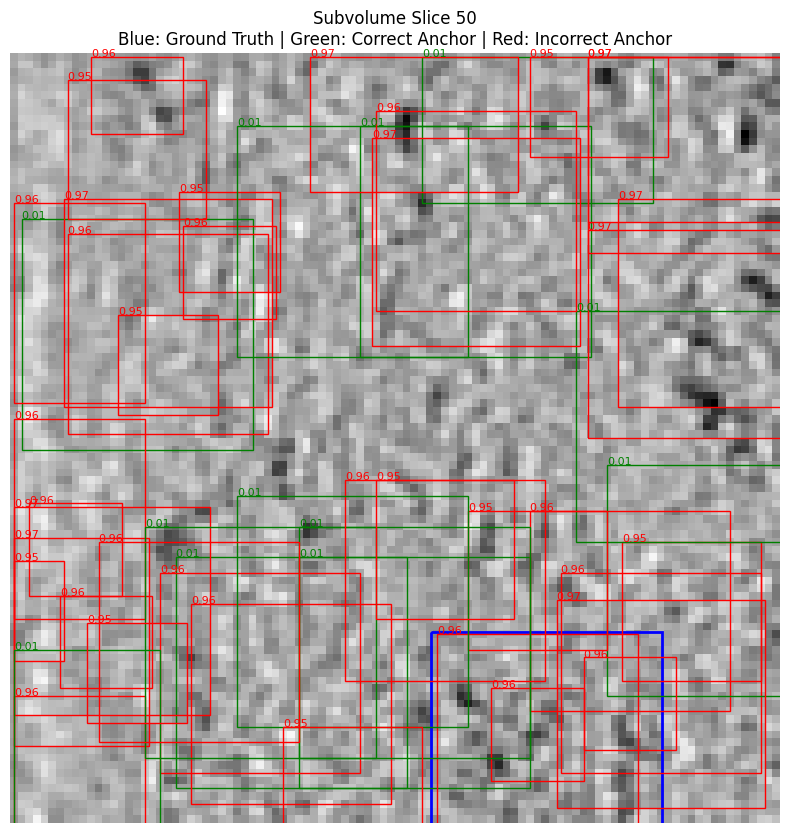

In [71]:
import random
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import tensorflow as tf

def visualize_training_subvolume(model, dataset, slice_index=50, threshold=0.5, num_anchors_to_draw=50):
    """
    Grabs one subvolume sample from the dataset (the same subvolume used during training),
    runs inference on it, and displays the chosen 2D slice with:
      - Ground truth boxes (in blue)
      - A subset of anchor boxes (drawn in green if the predicted objectness matches the ground truth,
        red otherwise) with the predicted objectness value printed near the box.
    
    Args:
        model: The Faster R-CNN model.
        dataset: A tf.data.Dataset that yields (inputs, labels) from your training subvolumes.
        slice_index (int): The index of the z-slice in the subvolume to display.
        threshold (float): Threshold on predicted objectness to decide positive (≥ threshold) vs negative.
        num_anchors_to_draw (int): Maximum number of anchor boxes to show.
    """
    # Get one sample from the dataset (batch size is assumed to be 1)
    for inputs, labels in dataset.take(1):
        break

    # Run inference on the sample
    pred_objectness, _ = model(inputs, training=False)
    
    # Convert tensors to numpy arrays
    # The subvolume image: shape (1, D, H, W, 1) => (D, H, W)
    subvol = inputs['tomogram'].numpy()[0, ..., 0]
    # Anchor boxes: shape (1, N, 6) => (N,6)
    anchor_boxes = inputs['anchor_boxes'].numpy()[0]
    # Ground truth boxes (adjusted to subvolume coordinates): shape (1, M, 6) => (M,6)
    gt_boxes = labels['ground_truth_boxes'].numpy()[0]
    # Ground truth objectness for each anchor (as created in the generator):
    gt_obj = labels['objectness_out'].numpy()[0]
    # Predicted objectness: shape (1, N) => (N,)
    pred_obj = pred_objectness.numpy()[0]
    
    # Determine which anchor boxes intersect the chosen slice.
    # (Anchor boxes are in the form: [x_min, y_min, z_min, x_max, y_max, z_max])
    anchor_indices = []
    for i, box in enumerate(anchor_boxes):
        if box[2]*10 <= slice_index < box[5]*10:
            anchor_indices.append(i)
    if len(anchor_indices) > num_anchors_to_draw:
        anchor_indices = random.sample(anchor_indices, num_anchors_to_draw)
    
    # Begin plotting the chosen subvolume slice.
    plt.figure(figsize=(10, 10))
    plt.imshow(subvol[slice_index], cmap='gray')
    ax = plt.gca()
    
    # Draw the ground truth boxes (if they span the slice) in blue.
    for box in gt_boxes:
        if box[2]-10 <= slice_index < box[5]+10:
            x_min, y_min, x_max, y_max = box[0], box[1], box[3], box[4]
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)
    
    # For each selected anchor box, decide on a color based on prediction correctness.
    # Here, predicted objectness is thresholded at the given value.
    for i in anchor_indices:
        box = anchor_boxes[i]
        predicted_val = pred_obj[i]
        predicted_label = 1 if predicted_val >= threshold else 0
        true_label = int(gt_obj[i])
        color = 'green' if predicted_label == true_label else 'red'
        
        # Only draw anchors that cover the slice.
        # For a 2D overlay, we use the (x_min, y_min, x_max, y_max) of the anchor box.
        x_min, y_min, x_max, y_max = box[0]*4, box[1]*4, box[3]*4, box[4]*4
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # Optionally, display the predicted objectness value near the box.
        ax.text(x_min, y_min, f"{predicted_val:.2f}", color=color, fontsize=8)
    
    plt.title(f"Subvolume Slice {slice_index}\nBlue: Ground Truth | Green: Correct Anchor | Red: Incorrect Anchor")
    plt.axis('off')
    plt.show()

# -------------------------
# Code to Run the Visualization
# -------------------------
# Assuming that:
#   - 'faster_rcnn_model' is your compiled model.
#   - 'dataset' is the tf.data.Dataset you prepared for training (which yields subvolume samples).
#   - The dataset batch size is 1 (as in the prepare_dataset() function).
#
# For example:

# Visualize slice 50 with default threshold and 50 random anchors from that subvolume.
visualize_training_subvolume(faster_rcnn_model, dataset, slice_index=50, threshold=0.5, num_anchors_to_draw=50)
